In [1]:
import numpy as np
from librosa.core import cqt
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from librosa.core import note_to_hz
import pandas as pd

from nnAudio import Spectrogram

import sys
sys.path.insert(0,'../')

import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1'

if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
from keras.models import Sequential
import kapre.time_frequency as time_frequency

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [3]:
y_list = np.load('./y_list.npy')

In [11]:
t_start = time.time()
model = Sequential()
model.add(time_frequency.Melspectrogram(sr=44100, n_dft=2048, n_hop=512, input_shape=(1,80000),
                         padding='same', n_mels=128,
                         fmin=0.0, fmax=44100/2, power_melgram=1.0,
                         return_decibel_melgram=False, trainable_fb=False,
                         trainable_kernel=False,
                         name='trainable_stft'))
model.summary()
time_used = time.time()-t_start
print(time_used)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
trainable_stft (Melspectrogr (None, 128, 157, 1)       4329600   
Total params: 4,329,600
Trainable params: 0
Non-trainable params: 4,329,600
_________________________________________________________________
0.39733123779296875


In [12]:
timing = []

for e in range(20):
    t_start = time.time()
    spec = model.predict(y_list.reshape(1770,1,80000))
    time_used = time.time()-t_start
    print(time_used)
    timing.append(time_used)

1.105238676071167
0.8837451934814453
0.8653130531311035
0.8768537044525146
0.8735547065734863
0.871490478515625
0.8682272434234619
0.865480899810791
0.8628010749816895
0.8702833652496338
0.8667030334472656
0.8649535179138184
0.8609883785247803
0.8604867458343506
0.8547019958496094
0.857445240020752
0.8665435314178467
0.864898681640625
0.8680558204650879
0.8777048587799072


In [13]:
print("mean = ",np.mean(timing))
print("std = ", np.std(timing))

mean =  0.879273509979248
std =  0.052281109303283176


In [14]:
data = pd.DataFrame(timing,columns=['t_avg'])
data['Type'] = 'kapre_GPU'

In [15]:
data.to_csv('Mel_kapre_GPU')

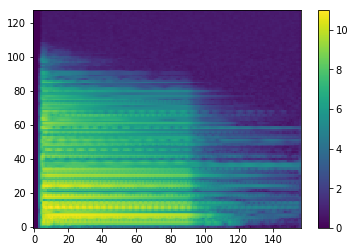

In [16]:
plt.imshow(np.log(spec[0][:,:,0]+1), aspect='auto', origin='lower')
plt.colorbar()

In [22]:
mel_layer = Spectrogram.MelSpectrogram(sr=44100)

STFT filter created, time used = 0.2689 seconds
Mel filter created, time used = 0.0039 seconds


In [23]:
y_torch = torch.tensor(y_list, dtype=torch.float)

In [24]:
spec_torch = mel_layer(y_torch)

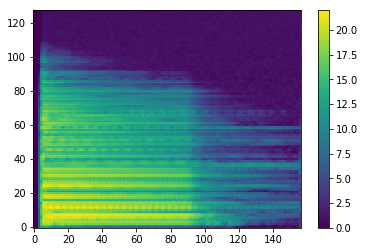

In [25]:
plt.imshow(torch.log(spec_torch[0]+1).cpu().numpy(), aspect='auto', origin='lower')
plt.colorbar()

In [26]:
np.log(spec[0][:,:,0]+1)

array([[0.        , 0.        , 0.        , ..., 0.8777554 , 1.2870595 ,
        1.4661566 ],
       [0.        , 0.        , 0.        , ..., 0.8257566 , 0.98830146,
        1.5060147 ],
       [0.        , 0.        , 0.        , ..., 1.2595114 , 1.2539351 ,
        1.6825526 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.88680995, 0.82320404,
        0.63842976],
       [0.        , 0.        , 0.        , ..., 0.7541375 , 0.7929155 ,
        0.7428506 ],
       [0.        , 0.        , 0.        , ..., 0.8149316 , 0.79127544,
        0.63000065]], dtype=float32)

In [27]:
torch.log(spec_torch[0]+1)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.9638, 2.3239, 3.7162],
        [0.0000, 0.0000, 0.0000,  ..., 0.8883, 1.6422, 3.7141],
        [0.0000, 0.0000, 0.0000,  ..., 2.0388, 2.1973, 3.8987],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.1064, 1.0129, 0.9063],
        [0.0000, 0.0000, 0.0000,  ..., 0.8124, 0.8966, 1.0879],
        [0.0000, 0.0000, 0.0000,  ..., 0.9589, 0.9158, 0.8277]])

In [29]:
import librosa
from librosa.feature import melspectrogram

In [32]:
np.log(abs(melspectrogram(y_list[0], sr=44100))+1)

array([[0.        , 0.        , 0.        , ..., 0.9638316 , 2.3238757 ,
        3.7161741 ],
       [0.        , 0.        , 0.        , ..., 0.88825846, 1.6421628 ,
        3.7140622 ],
       [0.        , 0.        , 0.        , ..., 2.038764  , 2.197338  ,
        3.8987203 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.1063783 , 1.0128891 ,
        0.9062843 ],
       [0.        , 0.        , 0.        , ..., 0.8123897 , 0.8966413 ,
        1.0878567 ],
       [0.        , 0.        , 0.        , ..., 0.9589011 , 0.91582334,
        0.8276606 ]], dtype=float32)

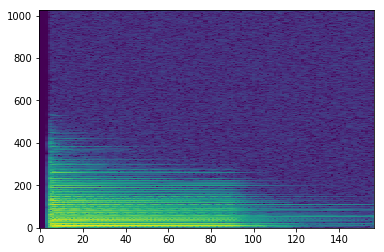

In [39]:
plt.imshow(np.log(abs(librosa.stft(y_list[0]))+1), aspect='auto', origin='lower')